In [1]:
import Distributions
import DataStructures
using Images

In [2]:
const alpha = 0.55
const h = 100
const top = h^alpha
function sampleDisplacement()
    u = rand()
    return (-((u * (top - 1) - top) / top))^(-1/alpha)
end

sampleDisplacement (generic function with 1 method)

In [3]:
const beta = 0.8
const h2 = 17
const top2 = h2^beta
function sampleDelay()
    u = rand()
    return (-((u * (top2 - 1) - top2) / top2))^(-1/beta)
end

sampleDelay (generic function with 1 method)

In [59]:
function gridCells(loc, r) :: Array{Array{Int,1}, 1}
    cells = Array{Array{Int,1}, 1}()
    angle = 1.0 / r
    for theta in angle:angle:(2*pi - angle)
        rot = [cos(theta), sin(theta)]
        push!(cells, trunc.(Int, loc + rot * r))
    end
    cells
end

gridCells (generic function with 1 method)

In [5]:
function sampleJump(loc, allVisits, r)
    whichCells = gridCells(loc, r)
    unnormalized = getindex.(allVisits, whichCells) + 1
    prob = unnormalized ./ sum(unnormalized)
    cell = rand(Distributions.Categorical(prob))
    whichCells[cell]
end
    

sampleJump (generic function with 1 method)

For a given frequency $f$ and even radius $r$, we plot the average over all cells of the number of visitors to this cell that came from truncated half distance $r/2$ away

In [49]:
function monoidDict(keys, vals)
    d = DataStructures.DefaultDict(typeof(keys[1]), typeof(vals[1]), 0)
    for i in 1:size(keys)[1]
        d[keys[i]] += vals[i]
    end
    d
end

monoidDict (generic function with 1 method)

In [51]:
dd = monoidDict(["ha", "ba"], [1, 2])

DataStructures.DefaultDict{String,Int64,Int64} with 2 entries:
  "ha" => 1
  "ba" => 2

In [54]:
for (k,v) in dd
    println(k, v)
end

ha1
ba2


The timescales don't match up. We need to only increment time by the smallest person's time jump

In [66]:
const rho = 0.6
const gamma = 0.21
const monthHours = 24 * 30

function walk(n)
    energy = zeros(100, 100)
    
    times = zeros(n)
    seen = ones(n)
    homes = rand(0:300,n,2)
    locs = copy(homes)
    allVisits = DataStructures.DefaultDict(Array{Int,1}, Int, 0)
    visits = [[1] for _ in 1:n]
    visitLoc = [[locs[i,:]] for i in 1:n]
    while all(times .< monthHours)
        for i in 1:n
            l = locs[i,:]
            allVisits[l] += 1
            if all(l .>= 100) && all(l .< 200)
                energy[(l - 99)...] += norm(homes[i,:] - l)
            end
            times[i] < monthHours || continue
            times[i] += sampleDelay()
            if rand() < rho * seen[i] ^ -gamma
                seen[i] += 1
                push!(visits[i], 1)
                loc = sampleJump(l, allVisits, sampleDisplacement())
                push!(visitLoc[i], loc)
                locs[i,:] = loc
            else
                sqvisits = visits[i].^2
                locid = rand(Distributions.Categorical(sqvisits / sum(sqvisits)))
                visits[i][locid] += 1
                locs[i,:] = visitLoc[i][locid]
            end
        end
    end
    freq_dist_count = zeros(Int, 10, 50) # map from frequency, distance/2 to count
    for i in 1:n
        for (k,v) in monoidDict(visitLoc[i], visits[i])
            halfdist = trunc(Int, norm(homes[i] - k) / 2)
            if halfdist < 50 && v > 0 && v <= 10
                freq_dist_count[v, halfdist + 1] += 1
            end
        end
    end
    energy, freq_dist_count
end

walk (generic function with 1 method)

In [68]:
energy, freqdist = walk(10000);

In [34]:
scaled = (g ./ maximum(g)) * 256

100×100 Array{Float64,2}:
  0.557737    0.313361   3.45143    …   0.388998    0.188609    0.0333417
 19.9912     12.9145     0.132157       0.354711    6.67431     0.0      
  0.0         3.55528    5.90481        0.360872    1.82309     0.0      
  0.0         1.55396    0.17955        0.0         0.0         2.47907  
  0.0         0.0972069  2.79441        0.0         4.69816     0.0      
  1.61061     0.0        5.36162    …  31.0032      4.80233     2.26864  
  0.0         0.213491   0.0            2.63956     0.235761    0.0      
  0.0         1.69056    1.14146        0.0471523   9.34825     8.83819  
  2.36177     0.100025   1.58703        1.50401     0.150961    0.0972069
  0.660552    0.0        5.67631        0.0         0.117881    0.330907 
  0.196261    1.60783    0.0        …   0.0         2.58855     0.149109 
  0.811238    0.80846    3.87412        1.40543     0.0         0.210871 
  0.407139    0.0        0.0            0.710915    0.0         0.201435 
  ⋮         

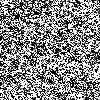

In [36]:
colorview(Gray, scaled)